In [1]:
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helpers import *

from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter, MultipleLocator

# pandas formatting
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 200)

In [2]:
# import tables
csas_requests = sql("SELECT * FROM csas2_csasrequest", database='dmapps_0')
request_reviewers = sql("SELECT * FROM csas2_requestreviewer", database='dmapps_0')
tors = sql("SELECT * FROM csas2_termsofreference", database='dmapps_0')
tor_reviewers = sql("SELECT * FROM csas2_torreviewer", database='dmapps_0')

TODO:
* histograms of days
* heatmap total days, days since reminder
* calculate number of business days on average, for 5 calendar days
* aggregate by number of reviewers

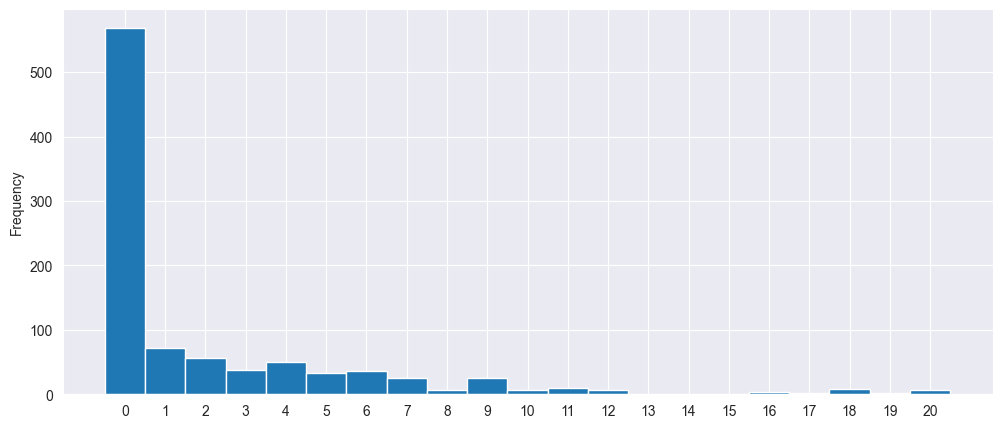

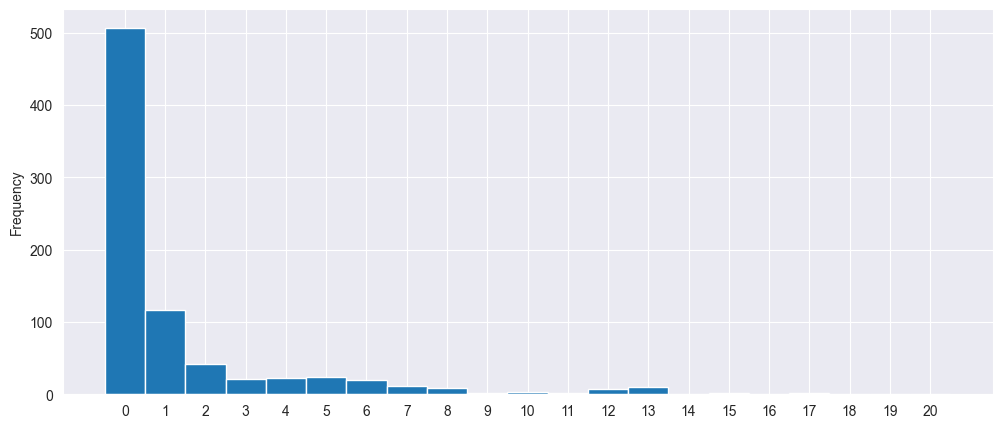

In [3]:
def plot_review_hist(dataframe, n_days=20, figsize=(12,5)):
    n_days += 1

    filtered_reviewers = dataframe[
        (dataframe.review_completed - dataframe.review_started).dt.days <= n_days
    ]
    
    diff_days = (filtered_reviewers.review_completed - filtered_reviewers.review_started).dt.days
    
    ax = diff_days.plot(
        kind='hist', 
        bins=n_days, 
        range=(0, n_days), 
        figsize=figsize
    )
    
    bin_edges = np.linspace(0, n_days, n_days + 1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    ax.set_xticks(bin_centers)
    ax.set_xticklabels([f"{int(center)}" for center in bin_centers])
    
    plt.show()


plot_review_hist(request_reviewers, 20)
plot_review_hist(tor_reviewers, 20)

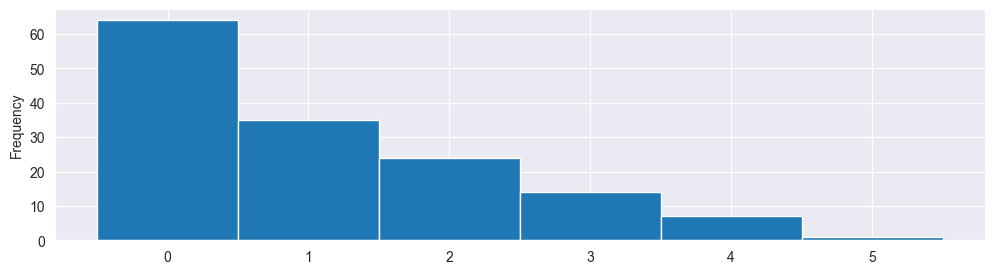

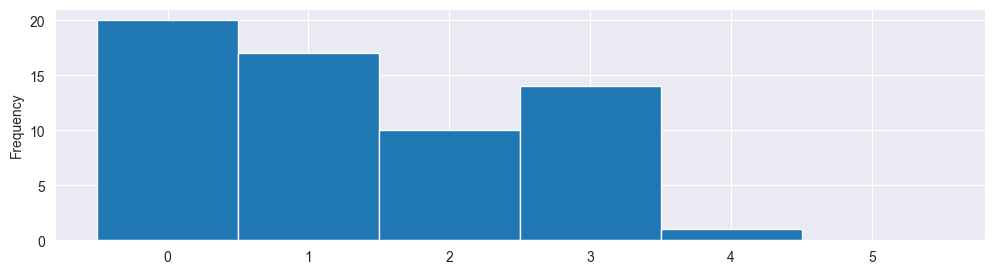

In [4]:
def days_since_notification_hist(dataframe, n_days=5, figsize=(12,3)):
    n_days += 1

    days_since_notification = (dataframe.review_completed - dataframe.reminder_sent).dt.days
    
    ax = days_since_notification.plot(
        kind='hist', 
        bins=n_days, 
        range=(0, n_days), 
        figsize=figsize
    )
    
    bin_edges = np.linspace(0, n_days, n_days + 1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    ax.set_xticks(bin_centers)
    ax.set_xticklabels([f"{int(center)}" for center in bin_centers])
    
    plt.show()
    
days_since_notification_hist(request_reviewers)
days_since_notification_hist(tor_reviewers)

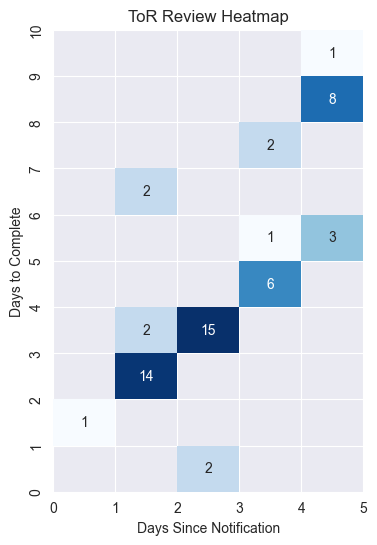

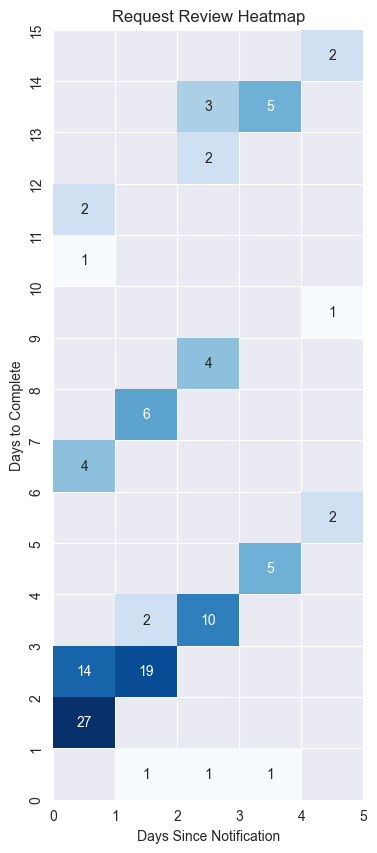

In [5]:
def plot_review_heatmap(dataframe, name, figsize=(4,8), xlim=5, ylim=15):
    days_to_complete = (dataframe.review_completed - dataframe.review_started).dt.days
    days_since_notification = (dataframe.review_completed - dataframe.reminder_sent).dt.days
    
    heatmap_data = pd.DataFrame({
        'Days to Complete': days_to_complete,
        'Days Since Notification': days_since_notification,
    })
    heatmap_data = heatmap_data[
        (heatmap_data['Days to Complete'] < ylim) &
        (heatmap_data['Days Since Notification'] < xlim)
    ]
    
    heatmap_pivot = heatmap_data.pivot_table(
        index='Days to Complete', 
        columns='Days Since Notification',
        aggfunc='size', 
        fill_value=0
    )
    heatmap_pivot = heatmap_pivot.where(heatmap_pivot > 0)

    plt.figure(figsize=figsize)
    ax = sns.heatmap(
        heatmap_pivot, 
        cmap='Blues', 
        annot=True, 
        cbar=False, 
        fmt='.0f',
        norm=LogNorm()
    )
 
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}'))
    ax.invert_yaxis()
    
    
    plt.title(f'{name} Review Heatmap')
    plt.xlabel('Days Since Notification')
    plt.ylabel('Days to Complete')
    plt.show()
    
    plt.show()
    
    
plot_review_heatmap(tor_reviewers, 'ToR', figsize=(4,6))
plot_review_heatmap(request_reviewers, 'Request', figsize=(4,10), ylim=20)

In [6]:
def days(dataframe):
    day_counts = (dataframe.review_completed - dataframe.reminder_sent).dt.days
    return day_counts.dropna().clip(lower=0, upper=4).astype(int).value_counts().sort_index()

print(days(request_reviewers))
print(days(tor_reviewers))

0    64
1    35
2    24
3    14
4    12
Name: count, dtype: int64
0    21
1    17
2    10
3    14
4     1
Name: count, dtype: int64


# how many business days is 5 calendar days?

In [7]:
def simulate_notification(n=5):
    n_stat_days = 11
    weekday = random.choice([x for x in range(7)])
    
    notification_day = weekday + n
    if  notification_day < 5:
        total_days = n
    elif notification_day == 5:
        total_days = n - 1
    elif notification_day == 6:
        total_days = n - 2
    else:
        total_days = n - 2 - random.choices([1, 0], weights=[n_stat_days, 52 - n_stat_days], k=1)[0]
            
    return total_days


In [8]:
n_simulations = 1000
results = pd.Series([simulate_notification() for _ in range(n_simulations)])

average = results.mean()
std_dev = results.std()
count_zeros = results.value_counts().get(0, 0)

print(f"Average: {average:.1f}")
print(f"Standard Deviation: {std_dev:.2f}")


Average: 3.0
Standard Deviation: 0.54


In [9]:
# what about 4 days? is that 2 business days? (pretty close)

n_simulations = 1000
results = pd.Series([simulate_notification(4) for _ in range(n_simulations)])

average = results.mean()
std_dev = results.std()
count_zeros = results.value_counts().get(0, 0)

print(f"Average: {average:.1f}")
print(f"Standard Deviation: {std_dev:.2f}")


Average: 2.3
Standard Deviation: 0.86


# how long vs how many reviewers?

In [10]:
def reviewers_vs_completion(dataframe, pk):
    dataframe['days_to_complete'] = (dataframe.review_completed - dataframe.review_started).dt.days

    result = dataframe.groupby(pk).agg(
        reviewer_count=('id', 'count'),
        days_to_complete=('days_to_complete', 'sum')
    ).reset_index()

    return result


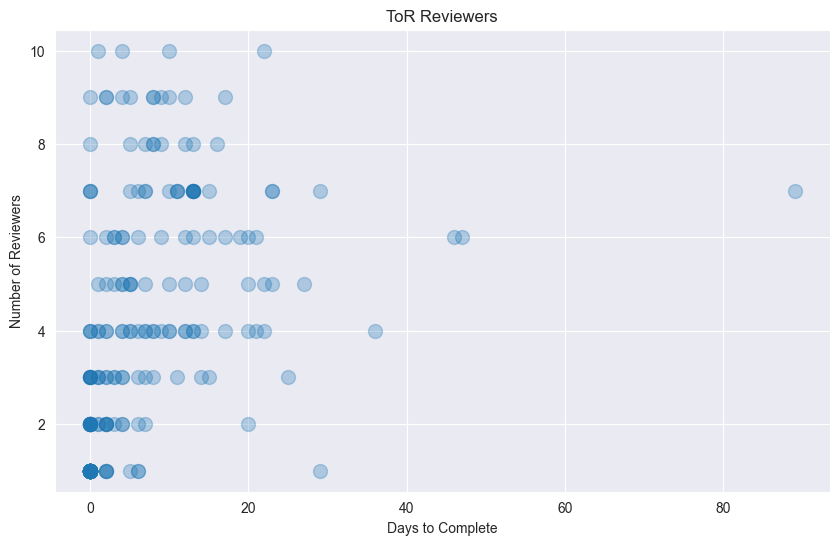

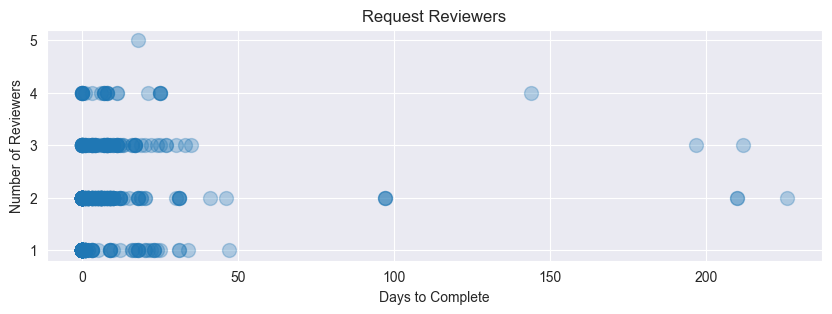

In [11]:
def plot_reviewers_vs_completion(dataframe, title, figsize=(10,6)):
    plt.figure(figsize=figsize)
    plt.scatter(dataframe['days_to_complete'], dataframe['reviewer_count'], alpha=0.3, s=100)
    
    plt.title(title)
    plt.xlabel('Days to Complete')
    plt.ylabel('Number of Reviewers')
    plt.grid(True)
    plt.show()
    

plot_reviewers_vs_completion(reviewers_vs_completion(tor_reviewers, 'tor_id'), 'ToR Reviewers')
plot_reviewers_vs_completion(reviewers_vs_completion(request_reviewers, 'csas_request_id'), 'Request Reviewers', (10,3))

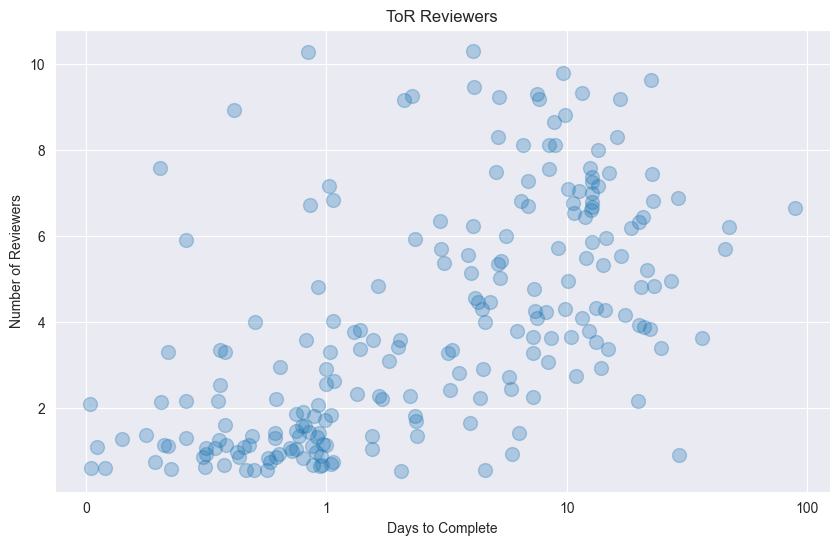

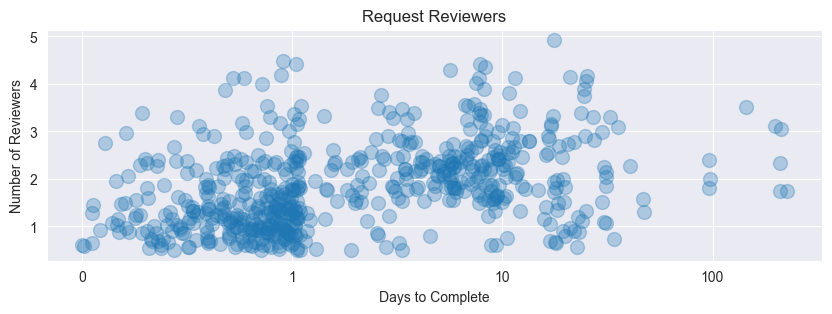

In [12]:
def plot_reviewers_vs_completion(dataframe, title, figsize=(10,6), wobble=0.5):
    reviewer_wobble = dataframe['reviewer_count'] + np.random.uniform(-wobble, wobble, len(dataframe))
    days_wobble = dataframe['days_to_complete'].clip(lower=wobble+0.1) + np.random.uniform(-wobble, wobble, len(dataframe))

    plt.figure(figsize=figsize)
    plt.scatter(days_wobble, reviewer_wobble, alpha=0.3, s=100)
    plt.xscale('log')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))
    
    plt.title(title)
    plt.xlabel('Days to Complete')
    plt.ylabel('Number of Reviewers')
    plt.grid(True)
    plt.show()
    

plot_reviewers_vs_completion(reviewers_vs_completion(tor_reviewers, 'tor_id'), 'ToR Reviewers')
plot_reviewers_vs_completion(reviewers_vs_completion(request_reviewers, 'csas_request_id'), 'Request Reviewers', (10,3))